In [1]:
### Set up environment
## Import libraries
import os
import pandas as pd
import numpy as np
import re
import scanpy as sc
from gtfparse import read_gtf
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
from scipy.spatial import distance_matrix
import anndata
from scipy.interpolate import InterpolatedUnivariateSpline
from sklearn.preprocessing import MinMaxScaler
import time

from pyInfinityFlow.InfinityFlow_Utilities import move_features_to_silent
from pyInfinityFlow.InfinityFlow_Utilities import anndata_to_df

os.chdir("/media/kyle_storage/kyle_ferchen/grimes_lab_main/analysis/"\
    "2022_12_07_new_multilin_panel/")

In [45]:
# Helper functions
print("Loading helper functions...")
def pprint(input_list):
    print("\n".join(input_list))


"""
scale_feature : this function is designed to remove outliers and fit the distribution into the range (0,1)

    parameters:
        input_array : (list-like), the feature values to scale
        min_threshold_percentile: (number between 0 to 100 inclusive), the minimum value for the input domain to be accepted, 
                        outliers below the percentile value given by this parameter will take on that minimum value
        max_threshold_percentile: (number between 0 to 100 inclusive), the maximum value for the input domain to be accepted, 
                        outliers above the percentile value given by this parameter will take on the maximum value

"""
def scale_feature(input_array, min_threshold_percentile, max_threshold_percentile):
    input_array = np.array(list(input_array))
    min_threshold = np.percentile(input_array, min_threshold_percentile)
    max_threshold = np.percentile(input_array, max_threshold_percentile)
    input_array[input_array < min_threshold] = min_threshold
    input_array[input_array > max_threshold] = max_threshold
    return(MinMaxScaler().fit(input_array.reshape(-1,1)).transform(input_array.reshape(-1,1)).reshape(-1,))


def make_spline_function_for_reference(reference_signal, n=100):
    start_time = time.time()
    # n = 100    # Number of points to consider during integration of KDE model
    # Build the KDE model
    reference_kde_model = stats.gaussian_kde(reference_signal)
    tmp_total_area = reference_kde_model.integrate_box_1d(0, 1)
    tmp_percentiles = np.array([reference_kde_model.integrate_box(0, tmp_point) / tmp_total_area for tmp_point in np.linspace(0,1,n)])
    # Remove values out of range
    flag_out_of_range = (tmp_percentiles <= 0) | (tmp_percentiles >= 1)
    x_spline = tmp_percentiles[~flag_out_of_range]
    y_spline = np.linspace(0,1,n)[~flag_out_of_range]
    # Remove duplicates
    flag_duplicates = np.unique(x_spline, return_index=True)[-1]
    x_spline = x_spline[flag_duplicates]
    y_spline = y_spline[flag_duplicates]
    # Add boundaries
    x_spline = np.concatenate(([0], x_spline, [1]))
    y_spline = np.concatenate(([0], y_spline, [1]))
    reference_spline_function = InterpolatedUnivariateSpline(x_spline, y_spline, k=1, bbox=[0,1], ext=3)
    end_time = time.time()
    print("\tSpline Function Built after {:.2f} seconds.".format(end_time - start_time))
    return(reference_spline_function)

def make_spline_function_for_reference_for_cartoon(reference_signal, n=100):
    start_time = time.time()
    # n = 100    # Number of points to consider during integration of KDE model
    # Build the KDE model
    reference_kde_model = stats.gaussian_kde(reference_signal)
    tmp_total_area = reference_kde_model.integrate_box_1d(0, 1)
    tmp_percentiles = np.array([reference_kde_model.integrate_box(0, tmp_point) / tmp_total_area for tmp_point in np.linspace(0,1,n)])
    # Remove values out of range
    flag_out_of_range = (tmp_percentiles <= 0) | (tmp_percentiles >= 1)
    x_spline = tmp_percentiles[~flag_out_of_range]
    y_spline = np.linspace(0,1,n)[~flag_out_of_range]
    # Remove duplicates
    flag_duplicates = np.unique(x_spline, return_index=True)[-1]
    x_spline = x_spline[flag_duplicates]
    y_spline = y_spline[flag_duplicates]
    # Add boundaries
    x_spline = np.concatenate(([0], x_spline, [1]))
    y_spline = np.concatenate(([0], y_spline, [1]))
    reference_spline_function = InterpolatedUnivariateSpline(x_spline, y_spline, k=1, bbox=[0,1], ext=3)
    end_time = time.time()
    print("\tSpline Function Built after {:.2f} seconds.".format(end_time - start_time))
    return(x_spline, y_spline, reference_spline_function)


def map_input_to_reference_spline(input_signal, reference_spline_function):
    input_ranks = pd.Series(\
        np.argsort(np.array(input_signal)), 
        index=list(range(len(input_signal)))).sort_values().index.values
    return(np.array([float(reference_spline_function(item)) for item in ((input_ranks + 1) / (len(input_signal)+2))]))



Loading helper functions...


In [3]:
### Reading in the data
## RNA
path_rna_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/analysis/"\
    "2022_07_07_tea_seq_atac_processing/"
adata_cite = sc.read(os.path.join(path_rna_data,
    "input/teaseq_pyharmony_knn_label_transfer/"\
    "cite_seq_adata_rna_combined.h5ad"))
print("Computing CPTT normalized scRNA-seq from CITE-seq...")
adata_cite.X = np.log2((10000 * (adata_cite.X.T / \
    adata_cite.X.sum(axis=1).T).T) + 1)
cite_cell_anno = pd.read_csv(os.path.join(path_rna_data,
    "input/teaseq_pyharmony_knn_label_transfer/"\
    "cite_seq_cell_annotations.csv"))
cite_cell_anno.index = cite_cell_anno["Cell_Barcode"].values

# Make pseudobulk RNA counts from cite clusters
print("Computing RNA centroids...")
shared_cells_cite = np.intersect1d(cite_cell_anno.index.values, 
    adata_cite.obs.index.values)
cite_cell_anno = cite_cell_anno.loc[shared_cells_cite]
cite_rna = {}
for tmp_cluster in cite_cell_anno["sctri_cite"].unique():
    print("\t{}...".format(tmp_cluster))
    tmp_barcodes = cite_cell_anno.loc[\
        cite_cell_anno["sctri_cite"] == tmp_cluster].index.values
    cite_rna[tmp_cluster] = pd.Series(np.asarray(\
            adata_cite[tmp_barcodes].X.mean(axis=0)).reshape(-1),
		index=adata_cite.var.index.values)

cite_rna = pd.DataFrame(cite_rna)
cite_rna = cite_rna.drop("Unknown", axis=1)
map_r7_names = pd.read_csv(os.path.join(path_rna_data,
    "input/map_r7-v1_to_r7-v2_names.csv"), 
    index_col=0).iloc[:,0]
cite_rna.columns = np.array([map_r7_names[item] for item in \
    cite_rna.columns.values])

Computing CPTT normalized scRNA-seq from CITE-seq...
Computing RNA centroids...
	ERP4--Ex...
	MultiLin-2_ML-c9--RNA...
	ERP2_Kit-c14--RNA...
	ERP2--Ex...
	Ebf1+_proB_CD127-c2--RNA...
	proNeu-1_1-4--ADT...
	Unknown...
	preNeu-2_1-8--ADT...
	cMoP_ML-c15--RNA...
	immNeu_Kit-c3--RNA...
	MP--Ex...
	proNeu-2_Kit-c4--RNA...
	Ebf1+_proB--Ex...
	ML_ERP1_ML-c4--RNA...
	MDP--Ex...
	preNeu-3_Kit-c2--RNA...
	ERP4_Kit-c13--RNA...
	preNeu-3_2-3--ADT...
	immNeu_2-5--ADT...
	preNeu-1_Kit-c5--RNA...
	immNeu_Kit-c1--RNA...
	cMoP--Ex...
	neoHPC_Myc--Ex...
	Bcl11b+_preETP--Ex...
	ML_Multi-Lin-2_HSC-c7--RNA...
	Ebf1+_proB_CD127-c8--RNA...
	IG2-proNeu1_ML-c14--RNA...
	ML_Mast--Ex...
	ML_cell_cycle_ML-c5--RNA...
	HSC-HPC-Cenpf_HSC-c12--RNA...
	MultiLin-2_ERP_ML-c10--RNA...
	ML_MDP_ML-c13--RNA...
	proNeu-1--Ex...
	SiglecH-Ly6C-pre-DC--Ex...
	HSC-HPC-Mki67--Ex...
	Pro-B_CD127-c3--RNA...
	precursor_B_cell_5-2--ADT...
	CLP1_CD127-c5--RNA...
	ML_MultiLin-1_ML-c8--RNA...
	ETP-A-0-Ccl4--Ex...
	ETP-CC-4-Ung--Ex...
	e

In [4]:
adata_cite.obs["port"] = ["_".join(item.split("_")[:-1]) for item in \
    adata_cite.obs.index.values]
adata_cite.obs["barcode"] = [item.split("_")[-1].split("-")[0] for item in \
    adata_cite.obs.index.values]
adata_cite.obs["port"].value_counts()

AS_CITE_Kit       11779
AS_3CITE_Kitx2    10095
AS_CITE_CD127      9842
AS_3CITE_Kit       9460
AS_CITE_HSC        9356
AS_CITE_ML1        9309
AS_CITE_ML2        7979
Name: port, dtype: int64

In [5]:
adata_cite.obs["port"] = adata_cite.obs["port"].replace({\
    "AS_CITE_ML1": "AS_CITE_Multilin1",
    "AS_CITE_ML2": "AS_CITE_Multilin2"})

In [6]:
# Rename observations in CITEseq adata object to match annotation
adata_cite.obs.index = adata_cite.obs["barcode"] + \
    "-1." + adata_cite.obs["port"]

In [7]:
## ADT
adt_titration = pd.read_feather("input/cite_seq_data/"\
    "kyle_denoised_adt_matrix_titration_dataset.feather").set_index("UID")
print("Shape of adt_titration: {}\n\n".format(adt_titration.shape))
adt_titration.head()

Shape of adt_titration: (88403, 197)




,CD11b,CD44,CD45_R,CD49f,KLRG_MAFA,Mac2_Galectin3,Integrin_B7,CD27,P2RY12,Rat_IgG1b_Isotype_Ctrl,...,TER_119,TIGIT_Vstm3,CD284,Tim_4,VISTA,CD29,CD61,CD62p,XCR1,CD90_1
UID,,,,,,,,,,,,,,,,,,,,,
Kit_CD117_AAACCCAAGAAGAGCA-1-0,42.949806,163.104780,0.409761,38.960518,13.082329,9.617719,0.143051,3.154802,6.154728,4.342930,...,0.327377,0.045957,0.246013,2.478646,15.713642,44.571987,6.657749,17.646290,1.975742,11.451635
Kit_CD117_AAACCCAAGAAGTCCG-1-0,54.399464,426.003880,0.158851,97.516710,15.264436,11.289984,1.285005,21.224367,6.598184,5.103056,...,0.048707,0.204520,0.496111,7.980790,19.263752,114.722280,11.748553,19.098034,2.309155,12.854566
Kit_CD117_AAACCCAAGCCGTCGT-1-0,0.046699,76.411224,0.000248,4.831459,5.959300,4.482401,0.061754,0.110969,0.015466,1.721350,...,0.074316,0.007046,0.000102,0.408142,3.258653,29.025608,0.008816,6.770806,1.069889,6.071065
Kit_CD117_AAACCCAAGGGTTAGC-1-0,1.481483,66.898260,6.254134,31.583057,14.580576,10.515202,0.183865,8.040592,5.244195,4.875021,...,0.049107,0.114150,0.123487,2.258008,14.618732,33.140884,1.409924,19.894337,2.112818,13.059340
Kit_CD117_AAACCCAAGTAGCATA-1-0,68.536870,376.493200,0.404842,67.476906,14.565544,10.866022,0.971949,13.568164,7.310145,5.118207,...,0.175489,0.108947,0.235170,6.996111,19.661366,88.105156,11.028669,19.422747,2.303972,12.505414


In [8]:
## Optimized CITE-seq ADT
adt = pd.read_table("input/cite_seq_data/optimized_cite_seq/"\
    "totalvi_denoised_adt_values_optimized_cite.txt",
    index_col=0)

adt.head()

,CD62L,CD183_CXCR3,CD14,CD170_Siglec_F,CX3CR1,CD4,CD8a,CD279_PD_1,CD117_c_kit,Ly_6C,...,CD95_Fas,CD159a_NKG2AB6,Ly108,CD85k_gp49_Receptor,CD51,CD205_DEC_205,CD155_PVR,anti_mouse_rat_CD81,CD135,CD127
UID,,,,,,,,,,,,,,,,,,,,,
AS_3CITE_Kit_AAACCCAAGAGAACCC-1-0,0.001651,9.094969,6.404634,4.835200,3.176729,0.002230,0.065455,24.835476,23.000551,0.021235,...,3.045355,0.005664,0.003475,0.312957,0.175547,0.034202,0.413599,17.638071,2.300927,0.014598
AS_3CITE_Kit_AAACCCAAGGACTAAT-1-0,5.115364,10.306177,7.413523,4.945864,3.508423,0.025171,0.021824,28.973675,25.960842,0.060741,...,3.374222,0.003530,0.059851,0.490206,0.155495,0.007698,1.578269,5.280829,2.956732,0.066672
AS_3CITE_Kit_AAACCCACAACCAATC-1-0,0.002983,8.158414,5.585370,4.490590,2.910414,0.001308,0.035764,21.645296,26.058890,0.017843,...,2.769812,0.001345,0.001102,0.394463,0.194356,0.021985,0.369483,18.389430,1.996135,0.012974
AS_3CITE_Kit_AAACCCACAAGGCAAC-1-0,0.022878,8.321768,5.891004,5.949375,3.177624,0.002719,0.039526,22.411037,32.127575,0.014023,...,2.979822,0.001753,0.003319,0.457861,0.378664,0.060850,0.816246,22.522966,2.085823,0.016361
AS_3CITE_Kit_AAACCCACAGATTTCG-1-0,1.055809,10.298586,8.065100,5.060285,3.602618,0.027931,0.209057,32.154926,24.433350,0.598676,...,3.720232,0.055793,8.238955,0.234276,0.229387,0.166728,1.772982,5.842451,3.178878,0.727068


In [9]:
## UMAP
umap = pd.read_table("input/cite_hive_integration/"\
    "hive_cite_umap_coordinates.tsv", index_col=0)
umap.head()

umap_anno = pd.DataFrame({\
    "port": [item.split(".")[-1] for item in umap.index.values],
    "barcode": [item.split("-")[0] for item in umap.index.values]},
    index=umap.index.values)
umap_anno.head()

umap_bounds = pd.concat([\
        pd.Series(umap.iloc[:,:2].min(axis=0), name="min"),
        pd.Series(umap.iloc[:,:2].max(axis=0), name="max")],
    axis=1)
padding = 0.05 * (umap_bounds["max"] - umap_bounds["min"])
umap_bounds["min"] = umap_bounds["min"] - padding
umap_bounds["max"] = umap_bounds["max"] + padding
umap_bounds

,min,max
UMAP_1,-13.415127,14.741054
UMAP_2,-15.299848,14.985798


In [10]:
## InfinityFlow
flow = anndata.read_h5ad("output/infinity_flow/"\
    "infinity_flow_reprediction_on_new_panal_logicle.h5ad")

In [11]:
feaures_to_exclude = [\
    "leiden",
    "Time",
    "SSC-W",
    "SSC-H",
    "SSC-A",
    "FSC-W",
    "FSC-H",
    "FSC-A",
    "SSC-B-W",
    "SSC-B-H",
    "SSC-B-A",
    "LIVEDEADBlue-A",
    "AF-A",
    "umap-x",
    "umap-y"]

flow = move_features_to_silent(flow, feaures_to_exclude)

In [12]:
# Rescale data to remove outliers
rescaled = flow.copy()
rescaled.X = anndata_to_df(rescaled).apply(lambda x: scale_feature(\
    x.values, 
    min_threshold_percentile=0.01, 
    max_threshold_percentile=99.99)).values

In [13]:
# Make a downsampled InfinityFlow dataset with 250k cells
sflow = rescaled[rescaled.obs.sample(int(2.5e5)).sort_values(\
    by="cell_number").index.values,:]

In [14]:
flow.obs

,cell_number
:0,0
:1,1
:2,2
:3,3
:4,4
...,...
:1935032,1935032
:1935033,1935033
:1935034,1935034
:1935035,1935035


In [15]:
## Merge cell names cite titration experiment
adt_titration_anno = pd.DataFrame({\
    "port": ["_".join(item.split("_")[:-1]) for item in \
        adt_titration.index.values],
    "barcode": [item.split("_")[-1].split("-")[0] for item in \
        adt_titration.index.values],
    "barcode_index": [item.split("-")[-2] for item in \
        adt_titration.index.values],
    "titration_index": [item.split("-")[-1] for item in \
        adt_titration.index.values]},
    index=adt_titration.index.values)

adt_titration_anno["port"] = adt_titration_anno["port"].replace(to_replace={\
    "Multi_Lin": "Multi_Lin-r2",
    "Kit_CD117": "Kit_CD117-r2",
    "Total_BM": "TotalBM-r2",
    "HSCP": "HSCP-r2",
    "CD127": "CD127-r2"})

adt_titration_anno["final"] = adt_titration_anno["barcode"] + \
    "-1." + adt_titration_anno["port"]

adt_titration_anno.head()
adt_titration.index = adt_titration_anno.loc[\
    adt_titration.index.values, "final"]

In [16]:
## Merge cell names optimized cite seq experiment
adt_anno = pd.DataFrame({\
    "port": ["_".join(item.split("_")[:-1]) for item in \
        adt.index.values],
    "barcode": [item.split("_")[-1].split("-")[0] for item in \
        adt.index.values],
    "barcode_index": [item.split("-")[-2] for item in \
        adt.index.values],
    "titration_index": [item.split("-")[-1] for item in \
        adt.index.values]},
    index=adt.index.values)

adt_anno["final"] = adt_anno["barcode"] + "-1." + adt_anno["port"]
adt.index = adt_anno.loc[adt.index.values, "final"]
adt_anno.index = adt_anno["final"]

In [17]:
print("Finding shared cells for titration data:")
shared_cells_titration = np.intersect1d(\
    adt_titration.index.values, 
    umap_anno.index.values)
len(shared_cells_titration)
c2_umap_titration = umap.loc[shared_cells_titration]
c2_adt_titration = np.log2(adt_titration.loc[shared_cells_titration] + 1)

print("Shape of umap with shared cells: {}".format(c2_umap_titration.shape))
print("Shape of adt with shared cells: {}".format(c2_adt_titration.shape))

Finding shared cells for titration data:
Shape of umap with shared cells: (77420, 2)
Shape of adt with shared cells: (77420, 197)


In [18]:
print("Finding shared cells for optimized cite-seq data:")
shared_cells = np.intersect1d(\
    adt.index.values, 
    umap_anno.index.values)
len(shared_cells)
c2_umap = umap.loc[shared_cells]
c2_adt = np.log2(adt.loc[shared_cells] + 1)

shared_cells_with_rna = np.intersect1d(adata_cite.obs.index.values,
    shared_cells)

print("Shape of umap with shared cells: {}".format(c2_umap.shape))
print("Shape of adt with shared cells: {}\n".format(c2_adt.shape))

print("{} shared cells with RNA values found.".format(\
    len(shared_cells_with_rna)))

Finding shared cells for optimized cite-seq data:
Shape of umap with shared cells: (57728, 2)
Shape of adt with shared cells: (57728, 112)

57728 shared cells with RNA values found.


In [19]:
rna_adt_name_map = pd.read_csv("input/map_rna_to_cite_adts.csv")
rna_adt_both = rna_adt_name_map.dropna()
rna_adt_titration_alone = rna_adt_name_map.loc[\
    rna_adt_name_map["OPTI_ADT"].isna()]

print("{} markers total.".format(rna_adt_name_map.shape[0]))
print("{} markers in both opti and titration experiments.".format(\
    rna_adt_both.shape[0]))
print("{} markers in titration alone.".format(rna_adt_titration_alone.shape[0]))


195 markers total.
106 markers in both opti and titration experiments.
89 markers in titration alone.


In [20]:
# # Plot CITE-OPTI RNA, CITE-OPTI ADT, and Titration ADT for overlapping features

# for i, row in rna_adt_both.iterrows():
#     print("Working on {} ({})...".format(row["OPTI_ADT"], row["RNA"]))

#     if row["RNA"] in adata_cite.var.index.values:
#         fig, ax = plt.subplots(1, 3, figsize=(18,6))

#         ax[0].set_title("CITE-Opti RNA")
#         ax[0].scatter(c2_umap.iloc[:,0], c2_umap.iloc[:,1], 
#             c=adata_cite[shared_cells,row["RNA"]].X.toarray().reshape(-1), 
#             cmap="jet", alpha=0.5, edgecolors=None, s=1)
#         ax[0].set_xlim(umap_bounds.iloc[0,:].values)
#         ax[0].set_ylim(umap_bounds.iloc[1,:].values)
#         ax[0].spines.right.set_visible(False)
#         ax[0].spines.top.set_visible(False)
#         ax[0].spines.bottom.set_visible(False)
#         ax[0].spines.left.set_visible(False)
#         ax[0].set_xticks([])
#         ax[0].set_yticks([])

#         ax[1].set_title("CITE-Opti ADT")
#         ax[1].scatter(c2_umap.iloc[:,0], c2_umap.iloc[:,1], 
#             c=c2_adt[row["OPTI_ADT"]], cmap="jet", alpha=0.5, 
#             edgecolors=None, s=1)
#         ax[1].set_xlim(umap_bounds.iloc[0,:].values)
#         ax[1].set_ylim(umap_bounds.iloc[1,:].values)
#         ax[1].spines.right.set_visible(False)
#         ax[1].spines.top.set_visible(False)
#         ax[1].spines.bottom.set_visible(False)
#         ax[1].spines.left.set_visible(False)
#         ax[1].set_xticks([])
#         ax[1].set_yticks([])

#         ax[2].set_title("CITE-Titration ADT")
#         ax[2].scatter(c2_umap_titration.iloc[:,0], c2_umap_titration.iloc[:,1], 
#             c=c2_adt_titration[row["TITRATION_ADT"]], cmap="jet", alpha=0.5,
#             edgecolors=None, s=1)
#         ax[2].set_xlim(umap_bounds.iloc[0,:].values)
#         ax[2].set_ylim(umap_bounds.iloc[1,:].values)
#         ax[2].spines.right.set_visible(False)
#         ax[2].spines.top.set_visible(False)
#         ax[2].spines.bottom.set_visible(False)
#         ax[2].spines.left.set_visible(False)
#         ax[2].set_xticks([])
#         ax[2].set_yticks([])

#         fig.suptitle("{} : {}".format(row["OPTI_ADT"], row["RNA"]))
#         plt.tight_layout()
#         plt.savefig(os.path.join("output/cite_seq/adt_markers_over_umap/"\
#             "opti_and_titration_intersect/{}-{}_marker_plot.png".format(\
#                 row["OPTI_ADT"], row["RNA"])))

#     else:
#         print("{} not in gene expression data...".format(row["RNA"]))

In [21]:
# # Plot CITE-OPTI RNA, and Titration ADT for overlapping features

# # Eg. ADT value c2_adt["anti_mouse_human_CD11b"]
# # Eg. Gene expression value adata_cite[shared_cells,"Irf8"].X.toarray().reshape(-1)

# fig, ax = plt.subplots(1, 3, figsize=(18,6))

# ax[0].set_title("CITE-Opti RNA")
# ax[0].scatter(c2_umap.iloc[:,0], c2_umap.iloc[:,1], c=adata_cite[shared_cells,"Il7r"].X.toarray().reshape(-1), cmap="jet", alpha=0.5,
#     edgecolors=None, s=1)
# # ax.scatter(umap_centroids.iloc[:,0].values, umap_centroids.iloc[:,1].values,
# #     color="red", edgecolors="black")
# # texts = [ax.text(\
# #     umap_centroids.loc[item][0],
# #     umap_centroids.loc[item][1],
# #     item) for item in umap_centroids.index.values]
# # adjust_text(\
# #     texts, 
# #     x=umap_centroids.iloc[:,0].values, 
# #     y=umap_centroids.iloc[:,1].values,
# #     arrowprops=dict(arrowstyle='->', color='blue'))
# ax[0].set_xlim(umap_bounds.iloc[0,:].values)
# ax[0].set_ylim(umap_bounds.iloc[1,:].values)
# ax[0].spines.right.set_visible(False)
# ax[0].spines.top.set_visible(False)
# ax[0].spines.bottom.set_visible(False)
# ax[0].spines.left.set_visible(False)
# ax[0].set_xticks([])
# ax[0].set_yticks([])

# ax[1].set_title("CITE-Opti ADT")
# ax[1].scatter(c2_umap.iloc[:,0], c2_umap.iloc[:,1], c=c2_adt["CD127"], cmap="jet", alpha=0.5,
#     edgecolors=None, s=1)
# ax[1].set_xlim(umap_bounds.iloc[0,:].values)
# ax[1].set_ylim(umap_bounds.iloc[1,:].values)
# ax[1].spines.right.set_visible(False)
# ax[1].spines.top.set_visible(False)
# ax[1].spines.bottom.set_visible(False)
# ax[1].spines.left.set_visible(False)
# ax[1].set_xticks([])
# ax[1].set_yticks([])

# ax[2].set_title("CITE-Titration ADT")
# ax[2].scatter(c2_umap_titration.iloc[:,0], c2_umap_titration.iloc[:,1], c=c2_adt_titration["CD127"], cmap="jet", alpha=0.5,
#     edgecolors=None, s=1)
# ax[2].set_xlim(umap_bounds.iloc[0,:].values)
# ax[2].set_ylim(umap_bounds.iloc[1,:].values)
# ax[2].spines.right.set_visible(False)
# ax[2].spines.top.set_visible(False)
# ax[2].spines.bottom.set_visible(False)
# ax[2].spines.left.set_visible(False)
# ax[2].set_xticks([])
# ax[2].set_yticks([])

In [20]:
adt_kit_cells = np.intersect1d(\
    adt_anno.loc[adt_anno["port"].isin(\
        ["AS_CITE_Kit", "AS_3CITE_Kit"])].index.values,
    shared_cells)
rna_kit_cells = np.intersect1d(\
    adt_kit_cells,
    shared_cells_with_rna)
len(rna_kit_cells)

18646

<AxesSubplot: xlabel='CD106', ylabel='Density'>

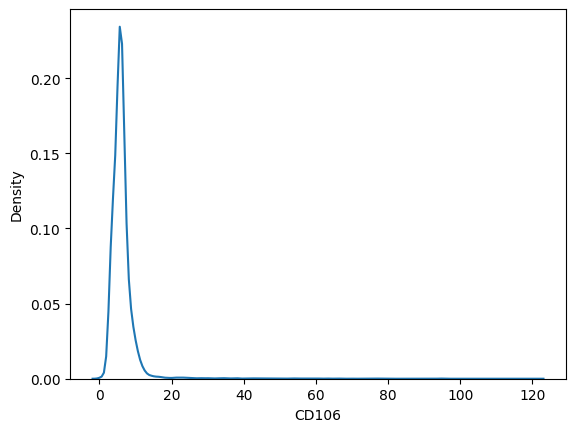

In [21]:
sns.kdeplot(adt.loc[adt_kit_cells, "CD106"])

<AxesSubplot: ylabel='Density'>

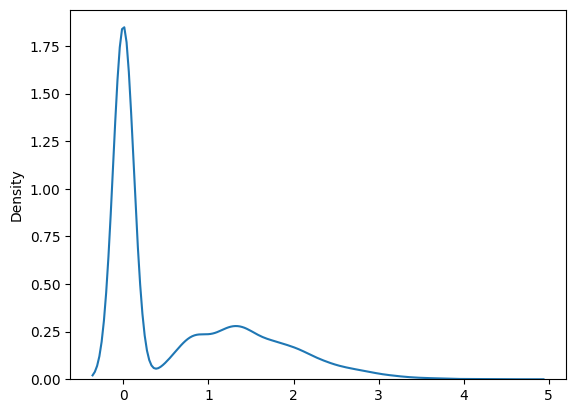

In [22]:
sns.kdeplot(adata_cite[rna_kit_cells,"Fcgr3"].X.toarray().reshape(-1))

<AxesSubplot: ylabel='Density'>

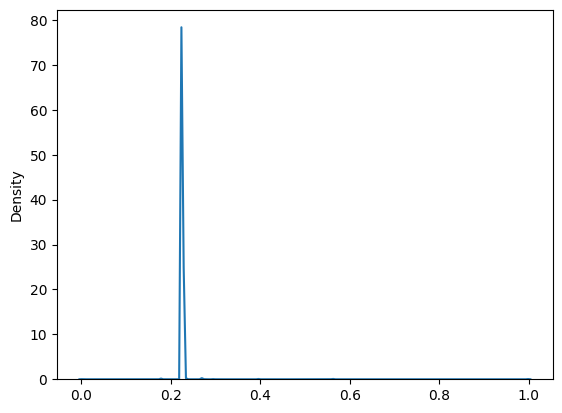

In [23]:
sns.kdeplot(sflow[:,"CD11c"].X.toarray().reshape(-1))

In [24]:
(sflow[:,"CD11c"].X.toarray().reshape(-1) > 0).sum()

249972

In [25]:
sflow[:,"CD11c"].X.toarray().reshape(-1).max()

1.0

In [26]:
## Read in table to map InfinityFlow channels to genes and adts
map_features = pd.read_csv("input/"\
    "map_rna_to_cite_adts_to_infinityflow_channels.csv")
map_features.head()

,OPTI_ADT,TITRATION_ADT,RNA,Channel,Name
0,CCR3_CD193,CD193,Ccr3,CD193,Imputed_CD193
1,CD102,CD102,Icam2,CD102,Imputed_CD102
2,CD105,CD105,Eng,BUV805-A,CD105
3,CD106,CD106,Vcam1,PerCP-Cy5.5-A,CD106
4,CD107a_LAMP_1,CD107a,Lamp1,CD107a,Imputed_CD107a


In [27]:
# Define base panel and mapped features
base_features = map_features.loc[\
    (~map_features["Name"].str.contains("Imputed", na=False)) & \
    (~map_features["Name"].isna())]

base_features

,OPTI_ADT,TITRATION_ADT,RNA,Channel,Name
2,CD105,CD105,Eng,BUV805-A,CD105
3,CD106,CD106,Vcam1,PerCP-Cy5.5-A,CD106
5,CD117_c_kit,CD117,Kit,BV650-A,CD117
8,CD127,CD127,Il7r,BV785-A,CD127
9,CD135,CD135,Flt3,PE-Cy5-A,CD135
12,CD150_SLAM,CD150,Slamf1,BV711-A,CD150
17,CD16_32,CD16_32,Fcgr3,BUV395-A,CD16_32
18,CD16_32,CD16_32,Fcgr2b,BUV395-A,CD16_32
29,CD201_EPCR,CD201,Procr,PerCP-eFluor710-A,CD201
48,CD371_CLEC12A,CD371,Clec12a,APC-A,CD371


In [28]:
links_adt = map_features.loc[\
    ~map_features["OPTI_ADT"].isna() & ~map_features["Channel"].isna()][\
        ["OPTI_ADT", "Channel"]]

links_adt = links_adt.loc[~links_adt.duplicated()]

print("{} links to build between ADT and InfinityFlow channels...".format(\
    links_adt.shape[0]))

links_rna = map_features.loc[\
    ~map_features["RNA"].isna() & ~map_features["Channel"].isna()][\
        ["RNA", "Channel"]]

links_rna = links_rna.loc[~links_rna.duplicated()]

# Filter RNA links to those in the dataset
links_rna = links_rna.loc[links_rna["RNA"].isin(adata_cite.var.index.values)]


print("{} links to build between RNA and InfinityFlow channels...".format(\
    links_rna.shape[0]))

93 links to build between ADT and InfinityFlow channels...
117 links to build between RNA and InfinityFlow channels...


In [29]:
channels_to_map_to = np.union1d(\
    np.unique(links_adt["Channel"].values), 
    np.unique(links_rna["Channel"].values))
len(channels_to_map_to)

114

In [46]:
### For example plot: just do CD27
ref_dist_map_functions = {}
test_x, test_y, test_func = make_spline_function_for_reference_for_cartoon(sflow[:,tmp_channel].X.toarray().reshape(-1))
ref_dist_map_functions["BUV737-A"] = test_func


	Spline Function Built after 4.55 seconds.


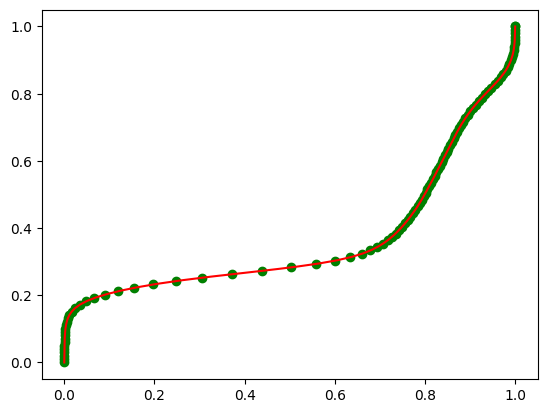

In [51]:
plt.close("all")
plt.scatter(test_x, test_y, color="green")
tmp_plot_x = np.linspace(0,1,1000)
plt.plot(tmp_plot_x, [test_func(i) for i in tmp_plot_x], color="red")
plt.savefig("output/example_kde_normalization_method_figures/cd27_infinityflow_spline_function.pdf")

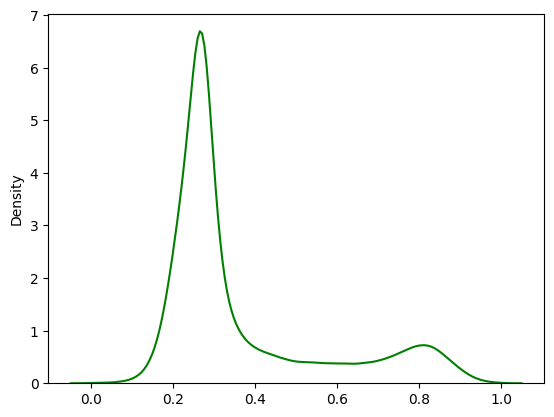

In [41]:
plt.close("all")
sns.kdeplot(sflow[:,tmp_channel].X.toarray().reshape(-1), color="green")
plt.savefig("output/example_kde_normalization_method_figures/cd27_infinityflow_distribution.pdf")

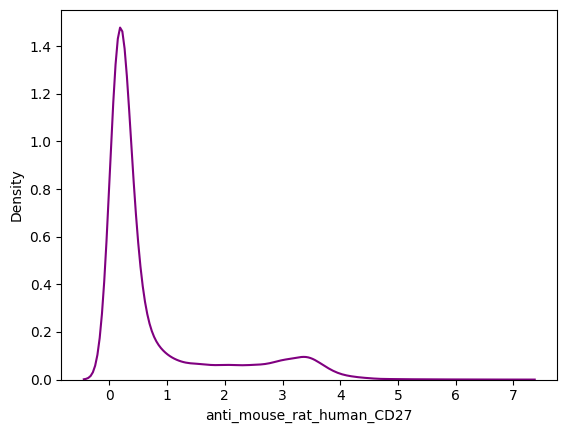

In [44]:
plt.close("all")
sns.kdeplot(np.log2(adt.loc[rna_kit_cells, "anti_mouse_rat_human_CD27"]+1), color="purple")
plt.savefig("output/example_kde_normalization_method_figures/cd27_cite_seq_kit_distribution_initial.pdf")

In [ ]:
adt_kit_cells = np.intersect1d(\
    adt_anno.loc[adt_anno["port"].isin(\
        ["AS_CITE_Kit", "AS_3CITE_Kit"])].index.values,
    shared_cells)

In [54]:
adt_anno["port"].value_counts()

AS_CITE_Kit          11509
AS_3CITE_Kitx2       10514
AS_CITE_CD127        10330
AS_3CITE_Kit         10226
AS_CITE_LPAM         10176
AS_CITE_HSC           9021
AS_CITE_Multilin1     8791
AS_CITE_Multilin2     8021
AS_3CITE_TNC          7536
Name: port, dtype: int64

In [60]:
adt_127_cells = adt_kit_cells = np.intersect1d(\
    adt_anno.loc[adt_anno["port"].isin(\
        ["AS_CITE_CD127"])].index.values,
    shared_cells)
adt_ml_cells = adt_kit_cells = np.intersect1d(\
    adt_anno.loc[adt_anno["port"].isin(\
        ["AS_CITE_Multilin1"])].index.values,
    shared_cells)
adt_hsc_cells = adt_kit_cells = np.intersect1d(\
    adt_anno.loc[adt_anno["port"].isin(\
        ["AS_CITE_HSC"])].index.values,
    shared_cells)

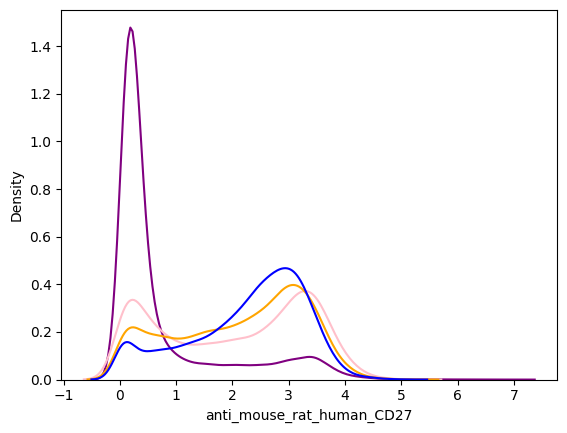

In [62]:
plt.close("all")
sns.kdeplot(np.log2(adt.loc[rna_kit_cells, "anti_mouse_rat_human_CD27"]+1), color="purple")
sns.kdeplot(np.log2(adt.loc[adt_127_cells, "anti_mouse_rat_human_CD27"]+1), color="pink")
sns.kdeplot(np.log2(adt.loc[adt_ml_cells, "anti_mouse_rat_human_CD27"]+1), color="orange")
sns.kdeplot(np.log2(adt.loc[adt_hsc_cells, "anti_mouse_rat_human_CD27"]+1), color="blue")
plt.savefig("output/example_kde_normalization_method_figures/cd27_cite_seq_distribution_initial_all_captures.pdf")

In [52]:
adt

,CD62L,CD183_CXCR3,CD14,CD170_Siglec_F,CX3CR1,CD4,CD8a,CD279_PD_1,CD117_c_kit,Ly_6C,...,CD95_Fas,CD159a_NKG2AB6,Ly108,CD85k_gp49_Receptor,CD51,CD205_DEC_205,CD155_PVR,anti_mouse_rat_CD81,CD135,CD127
final,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGAGAACCC-1.AS_3CITE_Kit,0.001651,9.094969,6.404634,4.835200,3.176729,0.002230,0.065455,24.835476,23.000551,0.021235,...,3.045355,0.005664,0.003475,0.312957,0.175547,0.034202,0.413599,17.638071,2.300927,0.014598
AAACCCAAGGACTAAT-1.AS_3CITE_Kit,5.115364,10.306177,7.413523,4.945864,3.508423,0.025171,0.021824,28.973675,25.960842,0.060741,...,3.374222,0.003530,0.059851,0.490206,0.155495,0.007698,1.578269,5.280829,2.956732,0.066672
AAACCCACAACCAATC-1.AS_3CITE_Kit,0.002983,8.158414,5.585370,4.490590,2.910414,0.001308,0.035764,21.645296,26.058890,0.017843,...,2.769812,0.001345,0.001102,0.394463,0.194356,0.021985,0.369483,18.389430,1.996135,0.012974
AAACCCACAAGGCAAC-1.AS_3CITE_Kit,0.022878,8.321768,5.891004,5.949375,3.177624,0.002719,0.039526,22.411037,32.127575,0.014023,...,2.979822,0.001753,0.003319,0.457861,0.378664,0.060850,0.816246,22.522966,2.085823,0.016361
AAACCCACAGATTTCG-1.AS_3CITE_Kit,1.055809,10.298586,8.065100,5.060285,3.602618,0.027931,0.209057,32.154926,24.433350,0.598676,...,3.720232,0.055793,8.238955,0.234276,0.229387,0.166728,1.772982,5.842451,3.178878,0.727068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGGCTGTG-1.AS_CITE_Multilin2,0.286228,13.179550,10.996012,7.297305,4.936492,0.223897,3.418811,40.143185,31.961746,8.511431,...,5.815585,0.953149,2.384893,0.512850,0.542875,2.680481,1.945465,12.875186,4.007118,0.260980
TTTGGTTTCGTACCTC-1.AS_CITE_Multilin2,0.719316,10.977038,7.811635,4.946914,3.931535,0.606132,0.079653,32.041400,33.866634,1.135569,...,3.771848,0.082064,0.264336,0.387080,0.251811,3.996131,2.662764,21.081604,3.251199,0.132410
TTTGGTTTCGTGTGAT-1.AS_CITE_Multilin2,0.137234,8.244141,6.269461,5.824542,2.822903,0.065185,0.108629,25.316717,26.563467,0.103873,...,3.063840,0.012840,0.008913,0.285703,0.142070,0.094923,1.698747,11.573400,2.307772,0.052130


In [36]:
test_vector = map_input_to_reference_spline(\
        adt.loc[rna_kit_cells, "anti_mouse_rat_human_CD27"], 
        ref_dist_map_functions["BUV737-A"])

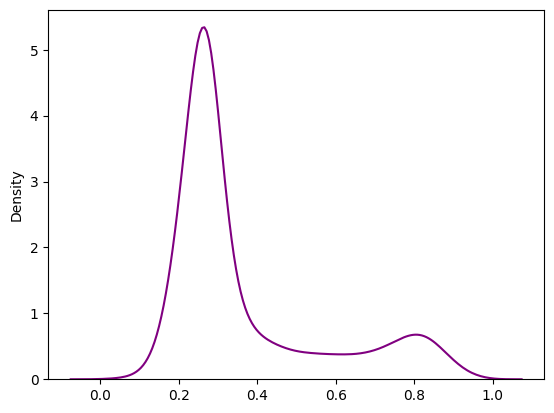

In [43]:
plt.close("all")
sns.kdeplot(test_vector, color="purple")
plt.savefig("output/example_kde_normalization_method_figures/cd27_cite_seq_kit_distribution_mapped.pdf")

In [32]:
# Build reference distribution map functions (Infinity Flow to CITE-seq)
ref_dist_map_functions = {}
for tmp_channel in channels_to_map_to:
    print("Working on {}...".format(tmp_channel))
    ref_dist_map_functions[tmp_channel] = make_spline_function_for_reference(\
        sflow[:,tmp_channel].X.toarray().reshape(-1))
    print("")

Working on APC-A...
	Spline Function Built after 4.30 seconds.

Working on APC-Cy7-A...
	Spline Function Built after 4.27 seconds.

Working on AlexaFluor647-A...
	Spline Function Built after 4.23 seconds.

Working on AlexaFluor700-A...
	Spline Function Built after 4.40 seconds.

Working on BUV395-A...
	Spline Function Built after 4.48 seconds.

Working on BUV615-A...
	Spline Function Built after 4.15 seconds.

Working on BUV737-A...
	Spline Function Built after 4.40 seconds.

Working on BUV805-A...
	Spline Function Built after 4.42 seconds.

Working on BV421-A...
	Spline Function Built after 2.77 seconds.

Working on BV480-A...
	Spline Function Built after 4.29 seconds.

Working on BV570-A...
	Spline Function Built after 4.49 seconds.

Working on BV605-A...
	Spline Function Built after 2.75 seconds.

Working on BV650-A...
	Spline Function Built after 4.54 seconds.

Working on BV711-A...
	Spline Function Built after 2.94 seconds.

Working on BV750-A...
	Spline Function Built after 4.58 

In [33]:
mapped_kit_cite_adt = {}
for i,row in links_adt.iterrows():
    print("Working on ADT link {}: {}:{}...".format(\
        i, row["OPTI_ADT"], row["Channel"]))
    mapped_kit_cite_adt[i] = map_input_to_reference_spline(\
        adt.loc[rna_kit_cells, row["OPTI_ADT"]], 
        ref_dist_map_functions[row["Channel"]])

mapped_kit_cite_adt = pd.DataFrame(mapped_kit_cite_adt, 
    columns=links_adt.index.values,
    index=rna_kit_cells)

mapped_kit_cite_adt.shape

Working on ADT link 0: CCR3_CD193:CD193...
Working on ADT link 1: CD102:CD102...
Working on ADT link 2: CD105:BUV805-A...
Working on ADT link 3: CD106:PerCP-Cy5.5-A...
Working on ADT link 4: CD107a_LAMP_1:CD107a...
Working on ADT link 5: CD117_c_kit:BV650-A...
Working on ADT link 6: CD11a:CD11a...
Working on ADT link 7: CD11c:CD11c...
Working on ADT link 8: CD127:BV785-A...
Working on ADT link 9: CD135:PE-Cy5-A...
Working on ADT link 10: CD14:CD14...
Working on ADT link 11: CD140a:CD140a...
Working on ADT link 12: CD150_SLAM:BV711-A...
Working on ADT link 13: CD155_PVR:CD155...
Working on ADT link 14: CD159a_NKG2AB6:CD159a...
Working on ADT link 15: CD163:CD163...
Working on ADT link 16: CD169_Siglec_1:CD169...
Working on ADT link 17: CD16_32:BUV395-A...
Working on ADT link 19: CD170_Siglec_F:CD170...
Working on ADT link 20: CD172a_SIRP:CD172a...
Working on ADT link 21: CD182_CXCR2:CD182...
Working on ADT link 22: CD183_CXCR3:CD183...
Working on ADT link 24: CD1d_CD1_1_Ly_38:CD1d...
Wo

(18646, 93)

<AxesSubplot: xlabel='99', ylabel='Density'>

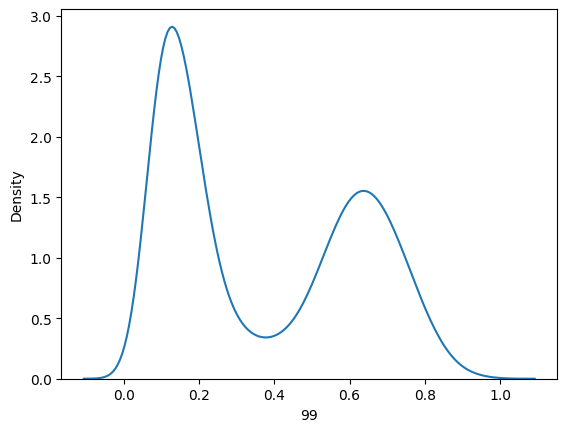

In [34]:
sns.kdeplot(mapped_kit_cite_adt[99])

In [35]:
mapped_kit_cite_rna = {}
for i,row in links_rna.iterrows():
    print("Working on RNA link {}: {}:{}...".format(\
        i, row["RNA"], row["Channel"]))
    mapped_kit_cite_rna[i] = map_input_to_reference_spline(\
        adata_cite[rna_kit_cells,row["RNA"]].X.toarray().reshape(-1), 
        ref_dist_map_functions[row["Channel"]])

mapped_kit_cite_rna = pd.DataFrame(mapped_kit_cite_rna, 
    columns=links_rna.index.values,
    index=rna_kit_cells)

mapped_kit_cite_rna.shape

Working on RNA link 0: Ccr3:CD193...
Working on RNA link 1: Icam2:CD102...
Working on RNA link 2: Eng:BUV805-A...
Working on RNA link 3: Vcam1:PerCP-Cy5.5-A...
Working on RNA link 4: Lamp1:CD107a...
Working on RNA link 5: Kit:BV650-A...
Working on RNA link 6: Itgal:CD11a...
Working on RNA link 7: Itgax:CD11c...
Working on RNA link 8: Il7r:BV785-A...
Working on RNA link 9: Flt3:PE-Cy5-A...
Working on RNA link 10: Cd14:CD14...
Working on RNA link 11: Pdgfra:CD140a...
Working on RNA link 12: Slamf1:BV711-A...
Working on RNA link 13: Pvr:CD155...
Working on RNA link 14: Klrc1:CD159a...
Working on RNA link 15: Cd163:CD163...
Working on RNA link 16: Siglec1:CD169...
Working on RNA link 17: Fcgr3:BUV395-A...
Working on RNA link 18: Fcgr2b:BUV395-A...
Working on RNA link 19: Siglece:CD170...
Working on RNA link 20: Sirpa:CD172a...
Working on RNA link 21: Cxcr2:CD182...
Working on RNA link 22: Cxcr3:CD183...
Working on RNA link 24: Cd1d1:CD1d...
Working on RNA link 25: Cd2:CD2...
Working on RNA

(18646, 117)

In [36]:
# Build spline functions to map remainder of CITE-seq cells to distribution
def predict_from_spline_map(x, input_spline_function, input_min, input_max):
    if x >= input_max:
        return(1)
    elif x <= input_min:
        return(0)
    else:
        return(input_spline_function(x))

In [37]:
shared_cells_non_kit = np.setdiff1d(shared_cells_with_rna, rna_kit_cells)
print("{} cells from capture other than Kit+...".format(\
    len(shared_cells_non_kit)))

39082 cells from capture other than Kit+...


In [38]:
mapped_non_kit_cite_adt = {}
for tmp_link in mapped_kit_cite_adt.columns.values:
    tmp_adt = links_adt.loc[tmp_link, "OPTI_ADT"]
    tmp_channel = links_adt.loc[tmp_link, "Channel"]
    print("Working on ADT link {}, {}:{}...".format(\
        tmp_link,
        tmp_adt,
        tmp_channel))
    tmp_kit_true_values = adt.loc[rna_kit_cells, tmp_adt].values
    tmp_kit_mapped_values = mapped_kit_cite_adt.loc[\
        rna_kit_cells, tmp_link].values
    tmp_input_minimum = min(tmp_kit_true_values)
    tmp_input_maximum = max(tmp_kit_true_values)
    tmp_spline_input_df = pd.DataFrame({\
        "x": tmp_kit_true_values,
        "y": tmp_kit_mapped_values}).sort_values(by="x")
    tmp_spline_input_df = tmp_spline_input_df.loc[\
        ~tmp_spline_input_df["x"].duplicated()]
    reference_spline_function = InterpolatedUnivariateSpline(\
        tmp_spline_input_df["x"].values, 
        tmp_spline_input_df["y"].values) # , k=1, bbox=[0,1], ext=3
    mapped_non_kit_cite_adt[tmp_link] = pd.Series([\
            predict_from_spline_map(\
                x=input, 
                input_spline_function=reference_spline_function, 
                input_min=tmp_input_minimum, 
                input_max=tmp_input_maximum) \
        for input in adt.loc[shared_cells_non_kit, tmp_adt].values],
        index=shared_cells_non_kit)

mapped_non_kit_cite_adt = pd.DataFrame(mapped_non_kit_cite_adt)


Working on ADT link 0, CCR3_CD193:CD193...
Working on ADT link 1, CD102:CD102...
Working on ADT link 2, CD105:BUV805-A...
Working on ADT link 3, CD106:PerCP-Cy5.5-A...
Working on ADT link 4, CD107a_LAMP_1:CD107a...
Working on ADT link 5, CD117_c_kit:BV650-A...
Working on ADT link 6, CD11a:CD11a...
Working on ADT link 7, CD11c:CD11c...
Working on ADT link 8, CD127:BV785-A...
Working on ADT link 9, CD135:PE-Cy5-A...
Working on ADT link 10, CD14:CD14...
Working on ADT link 11, CD140a:CD140a...
Working on ADT link 12, CD150_SLAM:BV711-A...
Working on ADT link 13, CD155_PVR:CD155...
Working on ADT link 14, CD159a_NKG2AB6:CD159a...
Working on ADT link 15, CD163:CD163...
Working on ADT link 16, CD169_Siglec_1:CD169...
Working on ADT link 17, CD16_32:BUV395-A...
Working on ADT link 19, CD170_Siglec_F:CD170...
Working on ADT link 20, CD172a_SIRP:CD172a...
Working on ADT link 21, CD182_CXCR2:CD182...
Working on ADT link 22, CD183_CXCR3:CD183...
Working on ADT link 24, CD1d_CD1_1_Ly_38:CD1d...
Wo

In [39]:
mapped_non_kit_cite_rna = {}
for tmp_link in mapped_kit_cite_rna.columns.values:
    tmp_rna = links_rna.loc[tmp_link, "RNA"]
    tmp_channel = links_rna.loc[tmp_link, "Channel"]
    print("Working on RNA link {}, {}:{}...".format(\
        tmp_link,
        tmp_rna,
        tmp_channel))
    tmp_kit_true_values = adata_cite[\
        rna_kit_cells,tmp_rna].X.toarray().reshape(-1)
    tmp_kit_mapped_values = mapped_kit_cite_rna.loc[\
        rna_kit_cells, tmp_link].values
    tmp_input_minimum = min(tmp_kit_true_values)
    tmp_input_maximum = max(tmp_kit_true_values)
    tmp_spline_input_df = pd.DataFrame({\
        "x": tmp_kit_true_values,
        "y": tmp_kit_mapped_values}).sort_values(by="x")
    tmp_spline_input_df = tmp_spline_input_df.loc[\
        ~tmp_spline_input_df["x"].duplicated()]
    reference_spline_function = InterpolatedUnivariateSpline(\
        tmp_spline_input_df["x"].values, 
        tmp_spline_input_df["y"].values) # , k=1, bbox=[0,1], ext=3
    mapped_non_kit_cite_rna[tmp_link] = pd.Series([\
            predict_from_spline_map(\
                x=input, 
                input_spline_function=reference_spline_function, 
                input_min=tmp_input_minimum, 
                input_max=tmp_input_maximum) \
        for input in adata_cite[\
            shared_cells_non_kit,tmp_rna].X.toarray().reshape(-1)],
        index=shared_cells_non_kit)

mapped_non_kit_cite_rna = pd.DataFrame(mapped_non_kit_cite_rna)

Working on RNA link 0, Ccr3:CD193...
Working on RNA link 1, Icam2:CD102...
Working on RNA link 2, Eng:BUV805-A...
Working on RNA link 3, Vcam1:PerCP-Cy5.5-A...
Working on RNA link 4, Lamp1:CD107a...
Working on RNA link 5, Kit:BV650-A...
Working on RNA link 6, Itgal:CD11a...
Working on RNA link 7, Itgax:CD11c...
Working on RNA link 8, Il7r:BV785-A...
Working on RNA link 9, Flt3:PE-Cy5-A...
Working on RNA link 10, Cd14:CD14...
Working on RNA link 11, Pdgfra:CD140a...
Working on RNA link 12, Slamf1:BV711-A...
Working on RNA link 13, Pvr:CD155...
Working on RNA link 14, Klrc1:CD159a...
Working on RNA link 15, Cd163:CD163...
Working on RNA link 16, Siglec1:CD169...
Working on RNA link 17, Fcgr3:BUV395-A...
Working on RNA link 18, Fcgr2b:BUV395-A...
Working on RNA link 19, Siglece:CD170...
Working on RNA link 20, Sirpa:CD172a...
Working on RNA link 21, Cxcr2:CD182...
Working on RNA link 22, Cxcr3:CD183...
Working on RNA link 24, Cd1d1:CD1d...
Working on RNA link 25, Cd2:CD2...
Working on RNA

In [40]:
mapped_cite_adt = pd.concat([mapped_kit_cite_adt, mapped_non_kit_cite_adt])
mapped_cite_rna = pd.concat([mapped_kit_cite_rna, mapped_non_kit_cite_rna])

print("Shape of mapped_cite_adt: {}".format(mapped_cite_adt.shape))
print("Shape of mapped_cite_rna: {}".format(mapped_cite_rna.shape))

Shape of mapped_cite_adt: (57728, 93)
Shape of mapped_cite_rna: (57728, 117)


In [41]:
# Write out the mapped data
# Have to make column names strings to save to feather
mapped_cite_adt.columns = [str(item) for item in mapped_cite_adt.columns.values]
mapped_cite_rna.columns = [str(item) for item in mapped_cite_rna.columns.values]
# Save feather
mapped_cite_adt.astype(float).reset_index().to_feather(\
    "output/cite_inflow_integration_input/mapped_cite_adt.feather")
mapped_cite_rna.astype(float).reset_index().to_feather(\
    "output/cite_inflow_integration_input/mapped_cite_rna.feather")


In [42]:
# Write out the links annotation dataframes for adt and rna
links_rna.to_csv("output/cite_inflow_integration_input/links_rna.csv", 
    header=True, index=True, index_label="Link")
links_adt.to_csv("output/cite_inflow_integration_input/links_adt.csv", 
    header=True, index=True, index_label="Link")

In [43]:
# Write out premapped values
premapped_cite_rna = pd.DataFrame(\
    adata_cite[\
        mapped_cite_rna.index.values,
        links_rna["RNA"].unique()].X.toarray(),
    index=mapped_cite_rna.index.values,
    columns=links_rna["RNA"].unique())

premapped_cite_rna.reset_index().to_feather(\
    "output/cite_inflow_integration_input/pre-mapped_cite_rna.feather")

adt.loc[\
    mapped_cite_adt.index.values, 
    links_adt["OPTI_ADT"].unique()].reset_index().to_feather(\
        "output/cite_inflow_integration_input/pre-mapped_cite_adt.feather")

In [44]:
# Write out the thresholds used to min-max scale the flow cytometry data
pd.DataFrame(\
    flow[:,:].X.toarray(), 
    columns=flow.var.index.values).apply(\
        lambda x: [np.percentile(x, 0.01), np.percentile(x, 99.99)]).to_csv(\
            "output/cite_inflow_integration_input/"\
            "inflow_rescaling_thresholds.csv",
            header=True, index=True, index_label="Threshold")